In [1]:
import torch
import torchvision
import torchinfo
import einops
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from icecream import ic

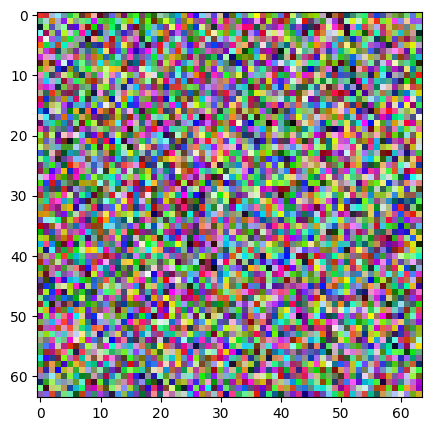

In [2]:
def imshow(img, figsize=(5, 5)):
    if isinstance(img, torch.Tensor):
        img = img.detach().numpy()

    if len(img.shape) == 4:
        img = img.squeeze(0)

    assert len(img.shape) == 3

    if img.shape[2] != 3:
        img = img.transpose(1, 2, 0)

    assert img.shape[2] == 3

    plt.figure(figsize=figsize)

    return plt.imshow(img)


testimage = np.random.randint(0,255, size = (1, 64, 64, 3))
imshow(testimage)

In [3]:
model = torchvision.models.resnet34(pretrained=True)

/Users/danesherburn/repos/feature-visualisation/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/danesherburn/repos/feature-visualisation/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
class Naivepixelparam(nn.Module):
    def __init__(self):
        super().__init__()
        self.img = nn.Parameter(torch.rand(1, 3, 224, 224))

    def forward(self):
        return torch.clip(self.img, min = 0, max = 1)


def optim_img(img: nn.Module, model: nn.Module, steps=1, logit=50, transforms=None):
    optimizer = torch.optim.Adam(img.parameters(), lr=0.05)

    for step in range(steps):
        optimizer.zero_grad()

        if transforms is not None:
            img = transforms(img())

        logits = model(img())
        loss = -logits[:, logit]  # [batch_size, class]
        loss.backward()
        optimizer.step()
    
    return img


transforms = torch.nn.Sequential(
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.RandomAffine(degrees=10, translate=(0.05, 0.05))
)

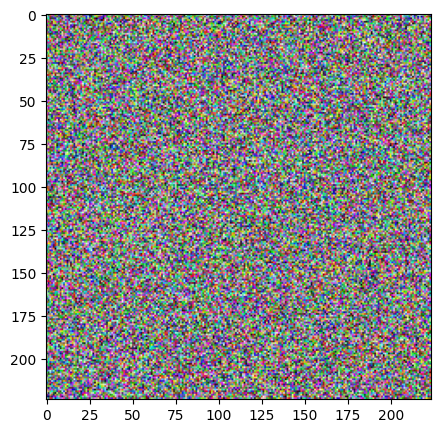

In [25]:
img_naive = Naivepixelparam()
imshow(img_naive())

In [26]:
img_naive = optim_img(img_naive, model, logit=150, steps=150, transforms=transforms)
imshow(img_naive())

TypeError: 'Tensor' object is not callable

In [10]:
class SigmoidPixelParam(nn.Module):
    def __init__(self):
        super().__init__()
        self.img = nn.Parameter(torch.randn(size=(1, 3, 224, 224)))

    def forward(self):
        return torch.nn.functional.sigmoid(self.img)

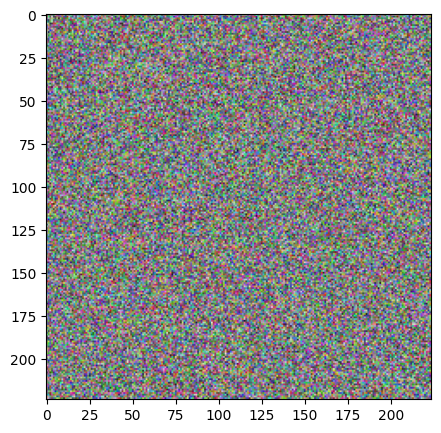

In [16]:
img_sigmoid = SigmoidPixelParam()
imshow(img_sigmoid())

/Users/danesherburn/repos/feature-visualisation/env/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


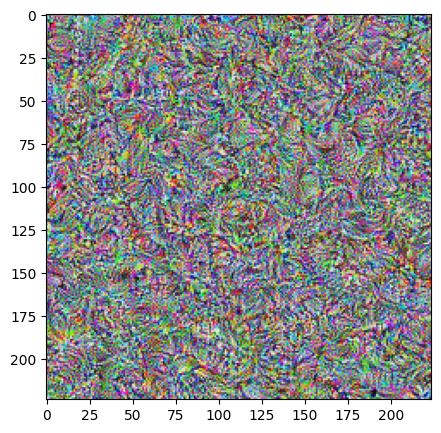

In [20]:
img_sigmoid = optim_img(img_sigmoid, model, logit=50, steps=300)
imshow(img_sigmoid())